# How pysubgroup works
just ignore the following code block for non technical people, but have a look at the example dataFrame (table) that we created

In [1]:
import pysubgroup as ps
import pandas as pd
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 300)
products = ['toast', 'bread', 'bread', 'toast', 'bread', 'bread','toast', 'bread', 'bread', 'pizza']
amount =  [100,1000,100,1000,10000,540,750,860,350,400]
was_fraud =  [1,0,0,0,1,1,1,0,0,0]
day_of_month = [15,20,30,17,12,7,11,14,20,27]
is_gold = [1,0,1,0,0,0,1,1,1,0]
df = pd.DataFrame.from_dict({'product': products, 'was_fraud': was_fraud, 'amount': amount, 'day_of_month' : day_of_month, 'is_gold':is_gold})
df

,product,was_fraud,amount,day_of_month,is_gold
0,toast,1,100,15,1
1,bread,0,1000,20,0
2,bread,0,100,30,1
3,toast,0,1000,17,0
4,bread,1,10000,12,0
5,bread,1,540,7,0
6,toast,1,750,11,1
7,bread,0,860,14,1
8,bread,0,350,20,1
9,pizza,0,400,27,0


In [2]:
target = ps.BinaryTarget('was_fraud', 1) # we are looking for fraud=1
search_space = ps.create_selectors(df, ignore='was_fraud') # define what we are looking for
search_space

[product=='toast',
 product=='bread',
 product=='pizza',
 amount<350,
 amount: [350:540[,
 amount: [540:860[,
 amount: [860:1000[,
 amount>=1000,
 day_of_month<12,
 day_of_month: [12:15[,
 day_of_month: [15:20[,
 day_of_month: [20:27[,
 day_of_month>=27,
 is_gold==0,
 is_gold==1]

As you can see, pysubgroup created selectors for us, treating nominal columns (product, is_gold) different from numeric columns (where it uses intervals selectors)
you can also create your own selectors see below

In [3]:
my_selector = ps.IntervalSelector('amount', 500, 25000)
print(my_selector)
search_space.append(my_selector) # add my selector to searchspace

amount: [500:25000[


Now that we have defined where we want to search we write all that information into a task object:

In [4]:
quality_function = ps.StandardQF(0) # Looks for subgroups with highest true positives ratio
min_quality = 0.2 # Minimum required quality = min true positive ratio
task = ps.SubgroupDiscoveryTask(df, target, search_space, quality_function, result_set_size=10, depth=3, min_quality=min_quality)

now that we have that task object we can run the algorithm (Here Depth first search)

In [5]:
result = ps.SimpleDFS().execute(task) # Run the algorithm
result.to_dataframe(include_info=True) # Show the output

,quality,description,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.6,amount: [500:25000[ AND amount: [540:860[ AND product=='toast',1,10,1,4,9,0.1,0.9,0.25,0.75,1.0,0.333333,0.4,2.5
1,0.6,amount: [500:25000[ AND day_of_month<12 AND product=='toast',1,10,1,4,9,0.1,0.9,0.25,0.75,1.0,0.333333,0.4,2.5
2,0.6,amount: [540:860[ AND day_of_month<12 AND product=='toast',1,10,1,4,9,0.1,0.9,0.25,0.75,1.0,0.333333,0.4,2.5
3,0.6,amount<350 AND product=='toast',1,10,1,4,9,0.1,0.9,0.25,0.75,1.0,0.333333,0.4,2.5
4,0.6,amount: [540:860[ AND product=='toast',1,10,1,4,9,0.1,0.9,0.25,0.75,1.0,0.333333,0.4,2.5
5,0.6,amount<350 AND day_of_month: [15:20[ AND product=='toast',1,10,1,4,9,0.1,0.9,0.25,0.75,1.0,0.333333,0.4,2.5
6,0.6,amount: [540:860[ AND is_gold==1 AND product=='toast',1,10,1,4,9,0.1,0.9,0.25,0.75,1.0,0.333333,0.4,2.5
7,0.6,day_of_month<12 AND is_gold==1 AND product=='toast',1,10,1,4,9,0.1,0.9,0.25,0.75,1.0,0.333333,0.4,2.5
8,0.6,day_of_month<12 AND product=='toast',1,10,1,4,9,0.1,0.9,0.25,0.75,1.0,0.333333,0.4,2.5
9,0.6,amount<350 AND is_gold==1 AND product=='toast',1,10,1,4,9,0.1,0.9,0.25,0.75,1.0,0.333333,0.4,2.5


Discarding 8 entities that are not covered


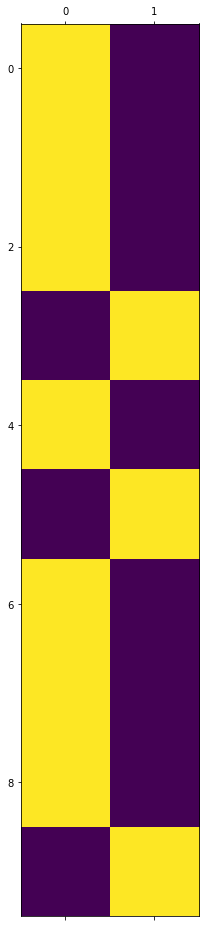

In [6]:
# Visualize resultset, see there is quite some redundancy
import matplotlib.pyplot as plt
plt.matshow(result.supportSetVisualization())

Discarding 4 entities that are not covered


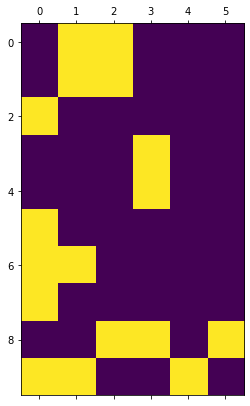

In [7]:
# we can already avoid redundancy a little but its quite slow!
quality_function = ps.GeneralizationAwareQF(ps.StandardQF(0)) # Looks for subgroups with highest true positives ratio, trying to avoid redundancy
task = ps.SubgroupDiscoveryTask(df, target, search_space, quality_function, result_set_size=10, depth=3, min_quality=min_quality)
result = ps.SimpleDFS().execute(task)
plt.matshow(result.supportSetVisualization())

In [8]:
result.to_dataframe(include_info=True) # Show the output, avoiding redundancy

,quality,description,size_sg,size_dataset,positives_sg,positives_dataset,size_complement,relative_size_sg,relative_size_complement,coverage_sg,coverage_complement,target_share_sg,target_share_complement,target_share_dataset,lift
0,0.600000,amount: [540:860[,2,10,2,4,8,0.2,0.8,0.50,0.50,1.000000,0.250000,0.4,2.500000
1,0.600000,day_of_month<12,2,10,2,4,8,0.2,0.8,0.50,0.50,1.000000,0.250000,0.4,2.500000
2,0.500000,amount<350 AND day_of_month: [15:20[,1,10,1,4,9,0.1,0.9,0.25,0.75,1.000000,0.333333,0.4,2.500000
3,0.500000,amount>=1000 AND day_of_month: [12:15[,1,10,1,4,9,0.1,0.9,0.25,0.75,1.000000,0.333333,0.4,2.500000
4,0.500000,day_of_month: [12:15[ AND is_gold==0,1,10,1,4,9,0.1,0.9,0.25,0.75,1.000000,0.333333,0.4,2.500000
5,0.500000,day_of_month: [15:20[ AND is_gold==1,1,10,1,4,9,0.1,0.9,0.25,0.75,1.000000,0.333333,0.4,2.500000
6,0.333333,is_gold==1 AND product=='toast',2,10,2,4,8,0.2,0.8,0.50,0.50,1.000000,0.250000,0.4,2.500000
7,0.333333,amount<350 AND product=='toast',1,10,1,4,9,0.1,0.9,0.25,0.75,1.000000,0.333333,0.4,2.500000
8,0.266667,is_gold==0 AND product=='bread',3,10,2,4,7,0.3,0.7,0.50,0.50,0.666667,0.285714,0.4,1.666667
9,0.266667,product=='toast',3,10,2,4,7,0.3,0.7,0.50,0.50,0.666667,0.285714,0.4,1.666667
